---
title: "Pan-UKB Hidden Factors v01"
author: "Saikat Banerjee"
format:
  html: default
date: "2023-12-12"
file-modified: "2023-12-12"
abstract: "We look at the hidden factors and their explanatory power"
    
---

# Getting Setup

In [1]:
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe, FrankWolfe_CV
from nnwmf.utils import model_errors as merr

import sys
sys.path.append("../utils/")
import simulate as mpy_simulate

# Load data and results

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/nnwmf"
zscore_filename = f"{data_dir}/GWAS_Zscore.tsv"
trait_filename = f"{data_dir}/trait_manifest_TableS6_no_readme.tsv"
zscore_df = pd.read_csv(zscore_filename, sep = '\t')
trait_df = pd.read_csv(trait_filename, sep = '\t')

# remove extra columns from trait_df

colnames = trait_df.columns.tolist()
colnames[0] = "zindex"
trait_df.columns = colnames
trait_df_mod = trait_df.drop(labels = ['coding', 'modifier', 'coding_description', 'filename', 'aws_link'], axis=1)
trait_df_mod['trait_name'] = trait_df_mod['description']
trait_df_mod['trait_name'] = trait_df_mod['trait_name'].fillna(trait_df_mod['phenocode'])

In [3]:
X_nan = np.array(zscore_df.loc[:, zscore_df.columns!='rsid']).T
X_nan_cent = X_nan - np.nanmean(X_nan, axis = 0, keepdims = True)
X_nan_mask = np.isnan(X_nan)
X_cent = np.nan_to_num(X_nan_cent, copy = True, nan = 0.0)

print (f"We have {X_cent.shape[0]} samples (phenotypes) and {X_cent.shape[1]} features (variants)")
print (f"Fraction of Nan entries: {np.sum(X_nan_mask) / np.prod(X_cent.shape):.3f}")

We have 2483 samples (phenotypes) and 51399 features (variants)
Fraction of Nan entries: 0.000


In [4]:
mf_methods = ['ialm', 'nnm_sparse', 'tsvd']

method_prefix = {
    'ialm' : 'ialm_maxiter10000_admm',
    'nnm_sparse' : 'nnm_sparse_maxiter1000'
}

method_names = {
    'tsvd' : 'Raw Data',
    'ialm' : 'RPCA-IALM',
    'nnm'  : 'NNM-FW',
    'nnm_weighted' : 'NNM-Weighted',
    'nnm_sparse' : 'NNM-Sparse-FW',
}

with open (f"{result_dir}/{method_prefix['ialm']}_progress.pkl", 'rb') as handle:
    ialm = pickle.load(handle)
    
with open (f"{result_dir}/{method_prefix['nnm_sparse']}_progress.pkl", 'rb') as handle:
    nnm_sparse = pickle.load(handle)

In [5]:
def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    loadings = Vt.T @ np.diag(S)
    return loadings, pcomps, S

lowrank_X = dict()
loadings  = dict()
pcomps    = dict()
eigenvals = dict()

for m in mf_methods:
    if m != 'tsvd':
        with open (f"{result_dir}/{method_prefix[m]}_lowrank_X.pkl", 'rb') as handle:
            lowrank_X[m] = pickle.load(handle)
lowrank_X['tsvd'] = X_cent.copy()
for m in mf_methods:
    loadings[m], pcomps[m], eigenvals[m] = get_principal_components(lowrank_X[m])

In [6]:
def get_cos2_scores(pcomps):
    ntrait, npcomp = pcomps.shape
    x = np.zeros((ntrait, npcomp))
    std_pcomps = pcomps / np.sqrt(np.var(pcomps[:,:], axis = 0))
    for i in range(ntrait):
        cos2_trait = np.array([np.square(std_pcomps[i, pcidx]) for pcidx in range(npcomp)])
        x[i, :] = cos2_trait / np.sum(cos2_trait)
    return x

def get_contribution_scores(pcomps):
    ntrait, npcomp = pcomps.shape
    x = np.zeros((ntrait, npcomp))
    std_pcomps = pcomps / np.sqrt(np.var(pcomps[:,:], axis = 0)).reshape(1, -1)
    for i in range(npcomp):
        trait_contr = np.array([np.square(std_pcomps[j, i]) for j in range(ntrait)])
        x[:, i] = trait_contr / np.sum(trait_contr)
    return x

npcomp = 100
cos2_scores = dict()
for m in mf_methods:
    cos2_scores[m] = get_cos2_scores(pcomps[m][:,:npcomp])

trait_contributions = dict()
for m in mf_methods:
    trait_contributions[m] = get_contribution_scores(pcomps[m][:,:npcomp])

# Explanatory power of hidden factors

For the top 20 principal components (hidden factors), we rank the cos2 scores for the top traits in @fig-hidden-factors

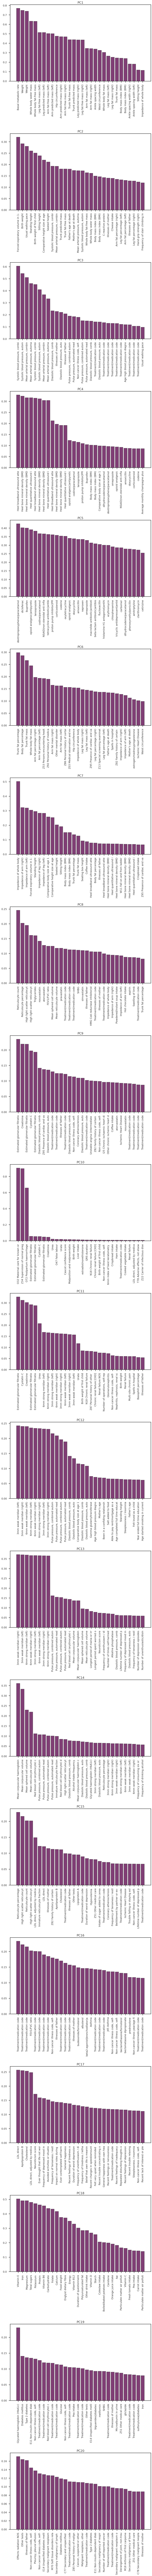

In [21]:
#| label: fig-hidden-factors
#| fig-cap: "Explanatory power of hidden factors. For each hidden factors (PC1 to PC20), we rank the diseases associated with the hidden factors."

imax = 30
npcomp = 20
m = 'ialm'

fig = plt.figure(figsize= (12, 10 * npcomp))
gs = GridSpec(nrows = npcomp, ncols=1, figure=fig, height_ratios=[1 for i in range(npcomp)])
ax = [None for i in range(npcomp)]

for i in range(npcomp):
    ax[i] = fig.add_subplot(gs[i, 0])

    top_trait_indices = np.argsort(cos2_scores[m][:, i])[::-1][:imax]
    top_trait_labels  = trait_df_mod.loc[top_trait_indices]['trait_name'].tolist()
    top_trait_labels  = [x[:30] for x in top_trait_labels]

    ax[i].bar(np.arange(imax), cos2_scores[m][top_trait_indices, i])
    ax[i].set_xticks(np.arange(imax))
    ax[i].set_xticklabels(top_trait_labels, rotation = 90, ha = 'center')
    ax[i].set_title(f"PC{i+1}")

plt.tight_layout(w_pad = 2.0)
plt.show()